# FINAL VERSION

# Initialization

In [1]:
# Once you have imported the environment (gym-Didi), comment these lines and reset the runtime before to execute the rest of the code

!unzip gym-Didi.zip
!pip install -e gym-Didi

In [ ]:
# Import libraries

import numpy as np 
import pandas as pd
import math 
import sys 
import networkx as nx
import time
import random
import datetime
import pickle

import matplotlib.pyplot as plt
import seaborn.apionly as sns  
import matplotlib.animation
from matplotlib import animation, rc
from IPython.display import HTML, Image
from IPython.display import clear_output
from scipy.signal import savgol_filter
import matplotlib.patches as mpatches

import gym
from gym import Env, spaces, error
from gym import utils
import gym_Didi

In [3]:
# Definition of environment characteristics

# Set global variables

num_nodes = 8 
num_actions = num_nodes + 2
node = 4 
new_node = node 

locs = [3, 6, 7]  # Nodes where the passenger can be picked up or dropped off
num_dest_idx = len(locs)
num_pass_idx = len(locs) + 1
num_states = num_nodes * num_dest_idx * num_pass_idx 
done = False 
reward = 0


# Graph definition

points_list = [(0, 1), (1, 2), (1, 3), (2, 3), (1, 5), (2, 7), (4, 5), (5, 6)]  # Graph edges
G = nx.Graph()
G.add_edges_from(points_list)
pos = nx.spring_layout(G)
A = nx.to_numpy_matrix(G, nodelist = [0, 1, 2, 3, 4, 5, 6, 7])  # Adjacency matrix


# Boolean variables

check_training = False # Set it to True to import old training lists
check_evaluation = False # Set it to True to import old evaluation lists

In [4]:
# Function to plot Didi's animation

rc('animation', html = 'html5') 

def update(num):
  global pos
  global locs
  global step
  global fig, ax
  global new_node
  global new_pass_idx
  global episode_action_e
  global episode_dest_idx_e
  global episode_new_pass_idx_e
  global episode_new_node_e
  global episode_pass_idx_e

  dest_node = [locs[episode_dest_idx_e[num]]] 
  didi_node = [episode_new_node_e[num]]
  
  ax.clear()      


  # Initial conditions  

  nx.draw_networkx_edges(G, pos = pos, edge_color = "black", node_size = 500)  # Edges color
  nx.draw_networkx_labels(G, pos)  # Labels color
  nx.draw_networkx_nodes(G, pos = pos, node_color = "white", edgecolors = 'black', node_size = 500)  # Nodes color

  nx.draw_networkx_nodes(G, pos = pos, node_color = "cornflowerblue", nodelist = dest_node, edgecolors = 'black', node_size = 500)  # It will change at the drop off time.
  

  # Didi conditions

  if episode_new_pass_idx_e[num] < len(locs):  # Didi empty
      nx.draw_networkx_nodes(G, pos = pos, node_color = "limegreen", nodelist = didi_node, edgecolors = 'black', node_size = 500)
      if (episode_new_node_e[num] != locs[episode_new_pass_idx_e[num]]) & (episode_action_e[num] == num_nodes):  # The empty Didi is on a node without the passenger and the Didi tries to pick up him (fail)
         nx.draw_networkx_nodes(G, pos = pos, node_color = "orange", nodelist = didi_node, edgecolors = 'black', node_size = 500) # The orange color is used when actions num_nodes and num_nodes + 1 are executed in the wrong position

  else:  # Didi full
        nx.draw_networkx_nodes(G, pos = pos, node_color = "red", nodelist = didi_node, edgecolors = 'black', node_size = 500)
        if  (episode_action_e[num] == num_nodes) :  # The Didi is full and it tries to pick up the passenger
             nx.draw_networkx_nodes(G, pos = pos, node_color = "orange", nodelist = didi_node, edgecolors = 'black', node_size = 500) 
             if episode_new_node_e[num] == locs[episode_pass_idx_e[num]]:
                nx.draw_networkx_nodes(G, pos = pos, node_color = "red", nodelist = didi_node, edgecolors = 'gold', node_size = 500)

  if (episode_new_node_e[num] != locs[episode_dest_idx_e[num]]) & (episode_action_e[num] == num_nodes + 1):  # The Didi is not on dest node and the action is drop off
            nx.draw_networkx_nodes(G, pos = pos, node_color = "orange", nodelist = didi_node, edgecolors = 'black', node_size = 500)


  # Dest_node conditions

  if episode_new_node_e[num] == locs[episode_dest_idx_e[num]]:  # Didi is on the destination node
     if episode_new_pass_idx_e[num] == len(locs) :  # The passenger is on the Didi
        nx.draw_networkx_nodes(G, pos = pos, node_color = "red", nodelist = dest_node, edgecolors = 'cornflowerblue', node_size = 500)  # The full Didi is on the destination node
     else:  # The passenger is not on the Didi
        nx.draw_networkx_nodes(G, pos = pos, node_color = "limegreen", nodelist = dest_node, edgecolors = 'cornflowerblue', node_size = 500)  # The empty Didi is on the destination node


  # Pass_node conditions

  if episode_new_pass_idx_e[num] < len(locs):  # Empty Didi
      pass_node = [locs[episode_new_pass_idx_e[num]]]
      nx.draw_networkx_nodes(G, pos = pos, node_color = "gold", nodelist = pass_node, edgecolors = 'black', node_size = 500)  # Passenger node
      if (episode_new_node_e[num] == locs[episode_new_pass_idx_e[num]]) & (locs[episode_new_pass_idx_e[num]] != locs[episode_dest_idx_e[num]]):  # The empty Didi is on the passenger node that is different from the destination node
         nx.draw_networkx_nodes(G, pos = pos, node_color = "limegreen", nodelist = pass_node, edgecolors = 'gold', node_size = 500)


  # When pass_idx = dest_idx

  if episode_pass_idx_e[num] == episode_dest_idx_e[num]:
     if episode_new_node_e[num] == locs[episode_pass_idx_e[num]]:
        eq_node = [locs[episode_pass_idx_e[num]]]
        nx.draw_networkx_nodes(G, pos = pos, node_color = "limegreen", nodelist = eq_node, edgecolors = 'gold', node_size = 500)
        if episode_action_e[num] == num_nodes:
           nx.draw_networkx_nodes(G, pos = pos, node_color = "red", nodelist = eq_node, edgecolors = 'gold', node_size = 500)
        if episode_action_e[num] == num_nodes + 1:
           nx.draw_networkx_nodes(G, pos = pos, node_color = "red", nodelist = eq_node, edgecolors = 'cornflowerblue', node_size = 500)  

# Q-Learning

In [5]:
class Agent:


  # Definition of parameters used for the epsilon policy (to balance exploration and exploitation) and for the Q-learning

  def __init__(self, n_states, n_actions, decay_rate = 0.00015, learning_rate = 0.001, gamma = 0.5):
    self.n_actions = n_actions
    self.q_table = np.zeros((n_states, n_actions))
    self.epsilon = 1.0
    self.max_epsilon = 1.0
    self.min_epsilon = 0.01
    self.decay_rate = decay_rate
    self.learning_rate = learning_rate
    self.gamma = gamma  # Discount rate
    self.epsilons_ = []


  # This function defines allowed actions for each node and selects one based on exploration or exploitation

  def choose_action(self, explore = True):
      exploration_tradeoff = np.random.uniform(0, 1)
      k = 0
      global new_node
      new_node = int(new_node)
      i = new_node
      for j in range(0, num_nodes):
          if A[i,j] == 1:
             k += 1
      a = np.zeros((k, 1)) 
      l = 0
      for j in range(0, num_nodes):
          if A[i,j] == 1:        
             a[l] = j
             l += 1    
      b = np.array([num_nodes, num_nodes+1])
      c = np.append(a, b)  # Allowed actions in a particular node
      global total_action       
      total_action = [-100000000000] * num_actions

      if explore and exploration_tradeoff < self.epsilon:  # Exploration
        m = np.random.randint(len(c))
        action = c[m]     
      else:   # Exploitation (taking the biggest Q value for this state)
            for j in c: 
              act = self.q_table[int(state), int(j)]
              total_action[int(j)] = act
              action = total_action.index(max(total_action))  
            
      return action


  # Learn function updates the Q-table and reduces epsilon when the task is over

  def learn(self, state, action, reward, new_state, done, episode):  
    # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
    self.q_table[state, action] = self.q_table[state, action] + \
      self.learning_rate * (reward + self.gamma * \
        np.max(self.q_table[new_state, :]) - self.q_table[state, action])
    
    if done:  # Reduce epsilon to decrease the exploration over time
      self.epsilon = self.min_epsilon + (self.max_epsilon - self.min_epsilon) * \
        np.exp(-self.decay_rate * episode)
      self.epsilons_.append(self.epsilon)

# Training

In [6]:
# Training conditions (total_episodes, env, agent) are defined

total_episodes = 10000
total_test_episodes = 1

env = gym.make('Didi-v0')  # Creation of the environment 
agent = Agent(num_states, env.action_space.n) 

print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))

action_size = env.action_space.n
print("Action size ", action_size)

state_size = env.observation_space.nvec
print("State size ", state_size)

Action Space Discrete(10)
State Space MultiDiscrete([8 4 3])
Action size  10
State size  [8 4 3]


In [7]:
# This part shows the way to work of an untrained Didi. All the actions are selected randomly

untrained_frames = []
pass_idx = 0
new_pass_idx = pass_idx
dest_idx = 1

for episode in range(total_test_episodes):

      state, new_state, new_node, reward = env.reset(pass_idx, dest_idx)  # Reset variables to initial conditions
      step = 1
      while True:

        action = agent.choose_action()       
        new_state, new_node, new_pass_idx, reward, done = env.step(action, pass_idx, new_pass_idx, dest_idx)  # Update variables        

        untrained_frames.append({
          'state': state,
          'episode': episode + 1,
          'step': step,
          'reward': reward
        })

        if done:  # The while loop will be over if the Didi completes the task or steps == 100
            step = 0
            break
        state = new_state
        step += 1
        if step == 100:
           break


In [8]:
# To visualize the evolution of state, episode and reward

def print_frames(frames):
  for i, frame in enumerate(frames):
    clear_output(wait=True)
    print(f"Episode: {frame['episode']}")
    print(f"Timestep: {frame['step']}")    
    print(f"State: {frame['state']}")
    print(f"Reward: {frame['reward']}")
    time.sleep(.5)

In [9]:
# Simultaneous visualization of state, episode, step and reward

print_frames(untrained_frames)

Episode: 1
Timestep: 99
State: 49.0
Reward: -10


In [10]:
# By importing training variables and q_table (agent_training) we don't need to execute again the training

if check_training == True:

  f = open("train.pkl", "rb")
  episode_new_pass_idx = pickle.load(f)
  episode_rewards = pickle.load(f)
  episode_action = pickle.load(f)
  episode_new_node = pickle.load(f)
  episode_new_state = pickle.load(f)
  rewards = pickle.load(f)
  act = pickle.load(f)
  rewards_sum = pickle.load(f)

  f = open("agent_train.pkl", "rb")
  agent.q_table = pickle.load(f)
  agent.epsilon = pickle.load(f)
  agent.max_epsilon = pickle.load(f)
  agent.min_epsilon = pickle.load(f)
  agent.decay_rate = pickle.load(f)
  agent.learning_rate = pickle.load(f)
  agent.gamma = pickle.load(f)
  agent.epsilons_ = pickle.load(f)

In [ ]:
# Training

if check_training == False:

  start = datetime.datetime.now()  # To know how much time is necessary to execute the training


  # Empty lists filled during the training and used to plot training results

  rewards = []
  rewards_sum = []
  act = []                                                                   


  # Empty lists filled during the training and used to store data

  episode_action = []
  episode_new_node = []
  episode_new_state = []
  episode_rewards = []
  episode_rewards_true = []
  episode_new_pass_idx = []


  for episode in range(total_episodes):

   if episode % 1000 == 0:
       print("Episode {} of {}".format(episode + 1, total_episodes))             
       end = datetime.datetime.now()
       delta = end - start
       print(delta)


       # Save lists

       f = open("train.pkl", "wb")  
       pickle.dump(episode_new_pass_idx, f)
       pickle.dump(episode_rewards, f)
       pickle.dump(episode_action, f)
       pickle.dump(episode_new_node, f)
       pickle.dump(episode_new_state, f)
       pickle.dump(rewards, f)
       pickle.dump(act,f)
       pickle.dump(rewards_sum, f)
       f.close()


       # Save the current q_table and the value we used to build it
       
       f = open("agent_train.pkl", "wb")  
       pickle.dump(agent.q_table, f)
       pickle.dump(agent.epsilon, f)
       pickle.dump(agent.max_epsilon, f)
       pickle.dump(agent.min_epsilon, f)
       pickle.dump(agent.decay_rate, f)
       pickle.dump(agent.learning_rate, f)
       pickle.dump(agent.gamma, f)
       pickle.dump(agent.epsilons_, f)
       f.close()


   for k in range(len(locs)):  # Sequence for pass_idx = 0, 1, 2                                                 

       for m in range(len(locs)):  # Sequence for dest_idx = 0, 1, 2                                             
              step = 1   
              pass_idx = k
              new_pass_idx = k
              dest_idx = m
              state, new_state, new_node, reward = env.reset(pass_idx, dest_idx)  # Reset variables to the initial conditions

              episode_rewards = [reward]
              episode_Action = []

              while True:
                    state = new_state 
                    action = agent.choose_action()  # The action is chosen based on exploration or exploitation                             

                    new_state, new_node, new_pass_idx, reward, done = env.step(action, pass_idx, new_pass_idx, dest_idx)  # Take an action and observe the outcomes of the step function

                    i_s = int(state)
                    i_n_s = int(new_state)
                    i_a = int(action)
                    agent.learn(i_s, i_a, reward, i_n_s, done, episode)  # Learning and Q-table

                    episode_rewards.append(reward)
                    episode_Action.append(action)
                    
                    step += 1
                    if done == True:
                      break
              
              if episode % 5000 == 0:  # It's useful to check at which combination the training is arrived and how many steps are executed for that task
                print("Pass_idx = {} dest_idx = {}".format(pass_idx, dest_idx)) 
                print(step)

              episode_rewards_true = episode_rewards[1:len(episode_rewards)] # It's necessary to trascuare the first element of episode_rewards because it's used to reset the reward and it's not a reward of an action
              act.append(len(episode_Action))
              rewards.append(np.mean(episode_rewards_true))
              rewards_sum.append(np.sum(episode_rewards_true))    



In [12]:
 # Not run this part of code if the training wasn't executed 

if check_training == False:

  # Time necessary to complete the training.

  end = datetime.datetime.now()
  C = end - start
  print(C)


  # Save lists.

  f = open("train.pkl", "wb")
  pickle.dump(episode_new_pass_idx, f)
  pickle.dump(episode_rewards, f)
  pickle.dump(episode_action, f)
  pickle.dump(episode_new_node, f)
  pickle.dump(episode_new_state, f)
  pickle.dump(rewards, f)
  pickle.dump(act, f)
  pickle.dump(rewards_sum, f)
  f.close()
    

  # Save the current q_table and the values we used to build it. Not run it if the training wasn't executed

  f = open("agent_train.pkl", "wb")
  pickle.dump(agent.q_table, f)
  pickle.dump(agent.epsilon, f)
  pickle.dump(agent.max_epsilon, f)
  pickle.dump(agent.min_epsilon, f)
  pickle.dump(agent.decay_rate, f)
  pickle.dump(agent.learning_rate, f)
  pickle.dump(agent.gamma, f)
  pickle.dump(agent.epsilons_, f)
  f.close()

0:02:23.303163


Text(0, 0.5, 'Total Mean Reward')

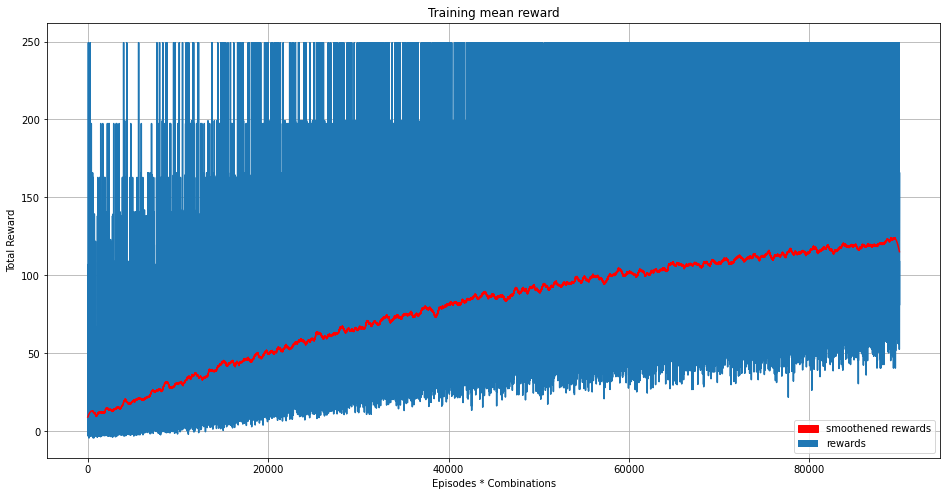

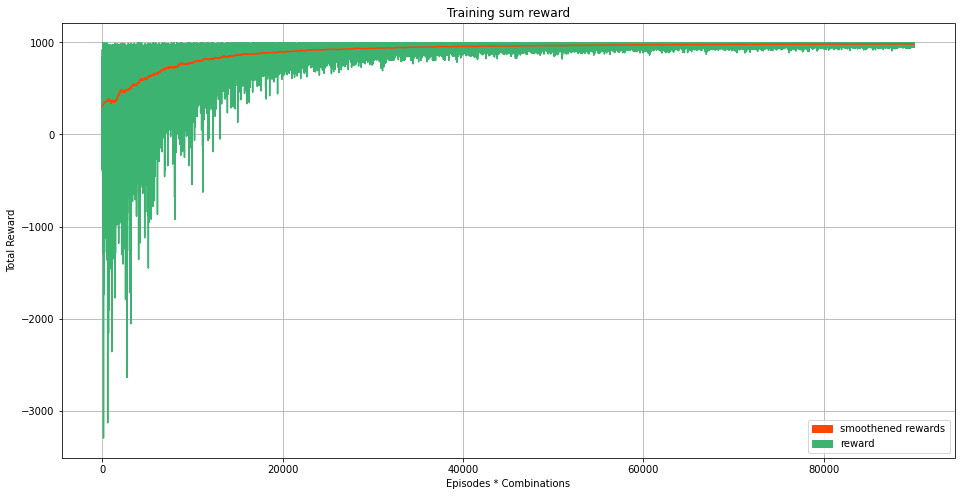

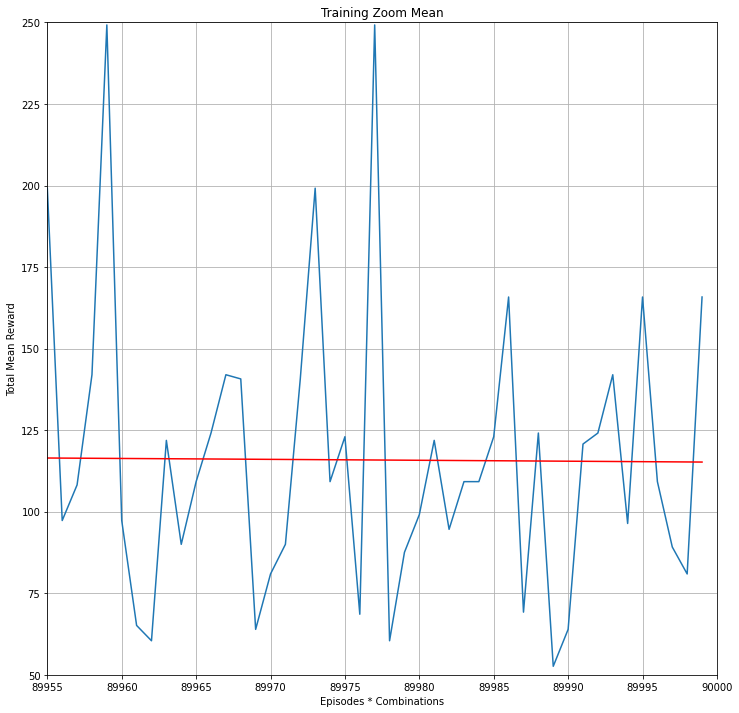

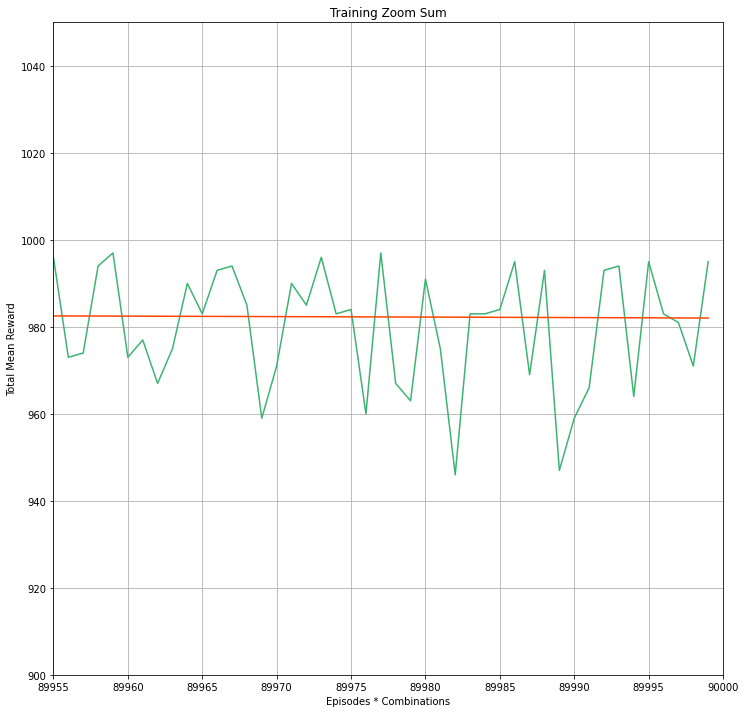

In [13]:
# Plot the mean reward got from the training


# Smoothened and unsmoothened mean reward

fig, ax = plt.subplots(figsize = (16, 8)) 
red_patch = mpatches.Patch(color = 'red', label = 'smoothened rewards')
blue_patch = mpatches.Patch( label = 'rewards')
plt.legend(handles = [red_patch, blue_patch])
plt.plot(rewards)
plt.plot(savgol_filter(rewards, 1001, 2), color = "red")
plt.title("Training mean reward")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Reward')
plt.grid()


#Smoothened and unsmothened sum-rewards

fig, ax = plt.subplots(figsize = (16, 8))
orange_patch = mpatches.Patch(color = 'orangered', label = 'smoothened rewards')
green_patch = mpatches.Patch( color = "mediumseagreen", label = 'reward')
plt.legend(handles = [orange_patch, green_patch])
plt.plot(rewards_sum, color = "mediumseagreen")
plt.plot(savgol_filter(rewards_sum, 1001, 2), color = "orangered")
plt.title("Training sum reward")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Reward')
plt.grid()


# Zoom of smoothened maximum mean reward

fig, ax = plt.subplots(figsize = (12, 12)) 
plt.plot(rewards)
plt.plot(savgol_filter(rewards, 1001, 2), color = "red")
plt.grid()
plt.ylim(50, 250)
plt.xlim(len(rewards) - (5 * num_dest_idx * (num_pass_idx - 1)), len(rewards));
plt.title("Training Zoom Mean")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Mean Reward')


# Zoom of smoothened sum-rewards

fig, ax = plt.subplots(figsize = (12, 12))
plt.plot(rewards_sum, color = "mediumseagreen")
plt.plot(savgol_filter(rewards_sum, 1001, 2), color = "orangered")
plt.grid()
plt.ylim(900, 1050)
plt.xlim(len(rewards) - (5 * num_dest_idx * (num_pass_idx - 1)), len(rewards));
plt.title("Training Zoom Sum")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Total Mean Reward')


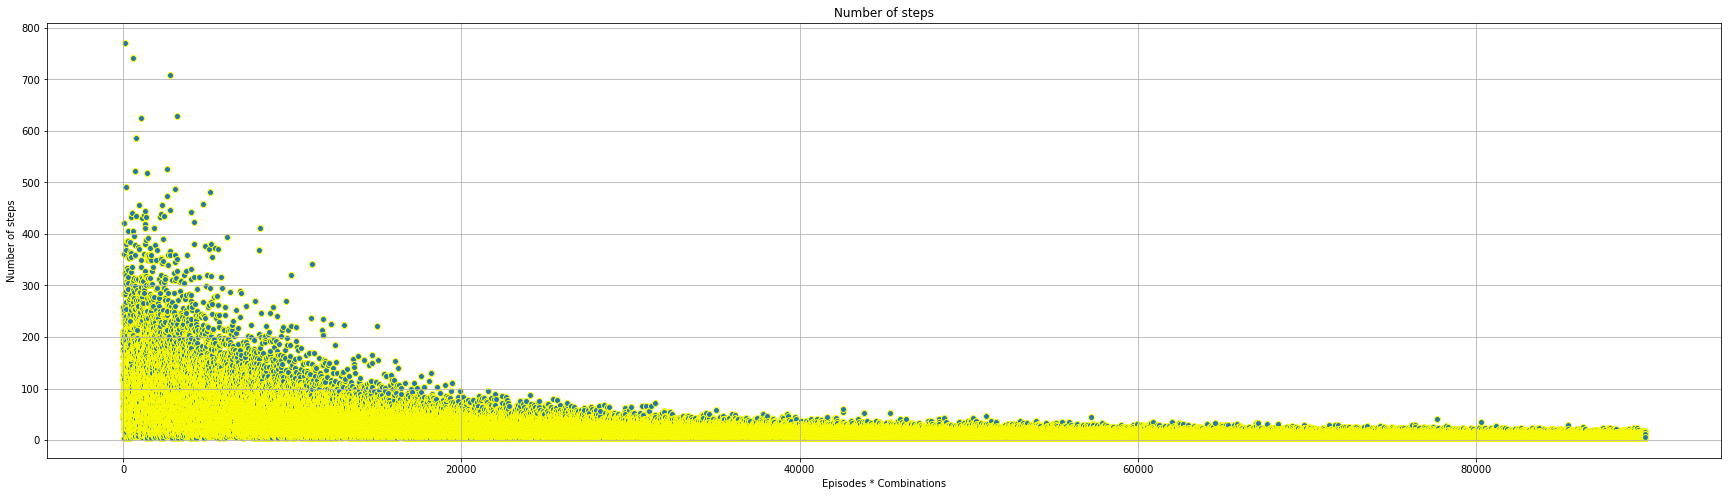

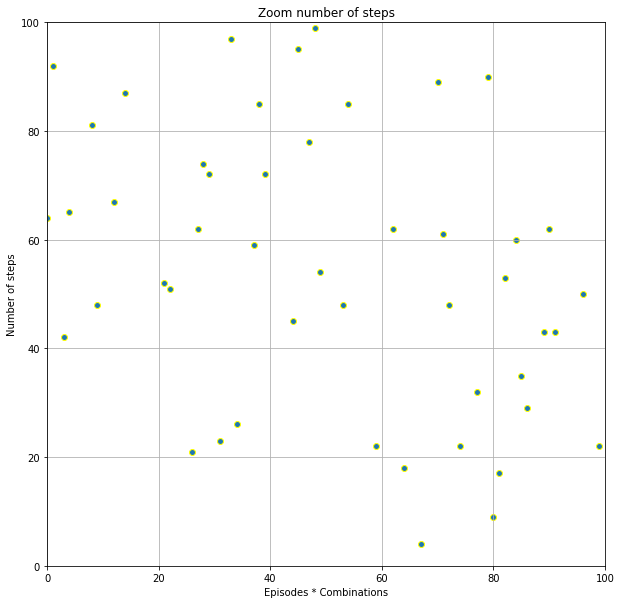

In [14]:
# Plot the number of steps taken to complete the task


# Number of steps to complete the task

fig, ax = plt.subplots(figsize = (30, 8))
plt.scatter([range(0, len(act))], act, edgecolors = "yellow" )
plt.title("Number of steps")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Number of steps')
plt.grid()


# Zoom to visualize it clearly

fig, ax = plt.subplots(figsize = (10, 10))
plt.scatter([range(0, len(act))], act, edgecolors = "yellow" )
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.title("Zoom number of steps")
plt.xlabel('Episodes * Combinations')
plt.ylabel('Number of steps')
plt.grid()

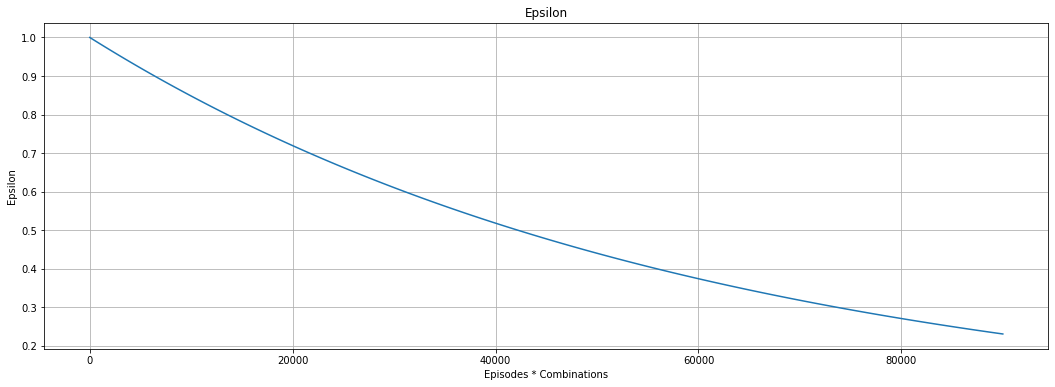

In [15]:
# Epsilon evolution plot

fig, ax = plt.subplots(figsize = (18, 6))
plt.plot(agent.epsilons_)
plt.title("Epsilon")
plt.xlabel('Episodes * Combinations');
plt.ylabel('Epsilon');
plt.grid()

# Evaluation

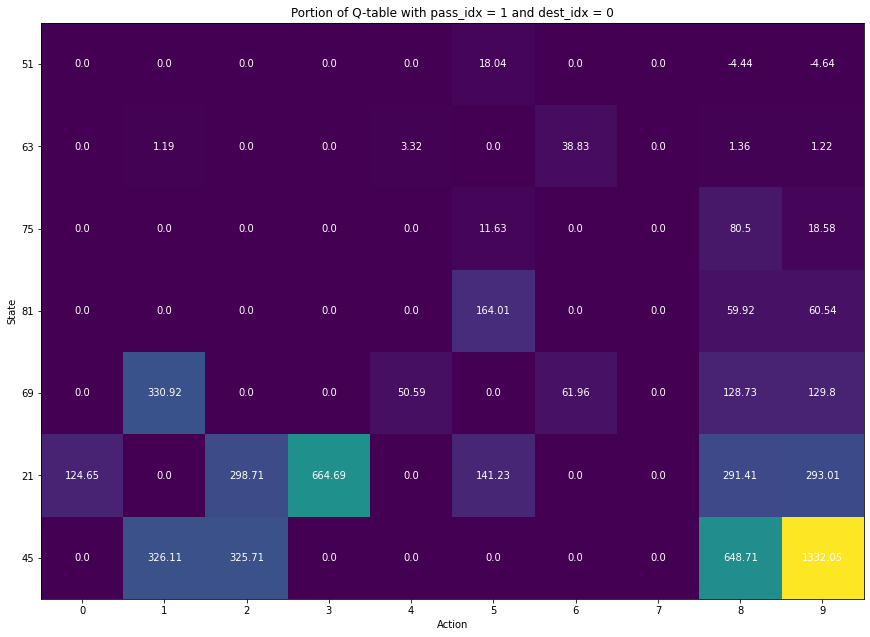

In [16]:
# Visualize a fraction of the Q_table for a specified task


fig, ax = plt.subplots(figsize = (12, 12))
aqtr = agent.q_table.round(2) # It's necessary to plot the q_values having a better visualization of it                                                   
aqt = aqtr[[51, 63, 75, 81, 69, 21, 45],:]   # We select the values of the sequence for the task we are interested in. In this we calculated the state values for the sequence pass_idx = 1 and dest_idx = 0 
im = ax.imshow(aqt)
ys = [51, 63, 75, 81, 69, 21, 45] 
xs = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
ax.set_xticks(np.arange(len(xs)))
ax.set_yticks(np.arange(len(ys)))
ax.set_xticklabels(xs)
ax.set_yticklabels(ys)

for i in range(0, 7):  # To fill the plot with numbers inside the box
    for j in range(0, 10):
        text = ax.text(j, i, aqt[i, j],
                       ha = "center", va = "center", color = "w")

ax.set_title("Portion of Q-table with pass_idx = 1 and dest_idx = 0")
fig.tight_layout()
plt.xlabel('Action')
plt.ylabel('State')
plt.show()

In [17]:
# By importing evaluation lists, it's not necessary to execute the evaluation code. We can move directly to the plot code

if check_evaluation == True: 

 f = open("eval.pkl", "rb")
 episode_action_e = pickle.load(f)
 episode_pass_idx_e = pickle.load(f)
 episode_new_pass_idx_e = pickle.load(f)
 episode_new_node_e = pickle.load(f)
 episode_dest_idx_e = pickle.load(f)
 episode_Action_e = pickle.load(f)
 episode_rewards_e = pickle.load(f)
 Rewards_e = pickle.load(f)
 act_e = pickle.load(f)
 Rewards_sum_e = pickle.load(f)
 frames = pickle.load(f)

In [18]:
#Evaluation

if check_evaluation == False:

  frames = []  # Empty list to display some values 


  # Empty lists filled during the evaluation and used to plot the animation

  episode_action_e = [] 
  episode_pass_idx_e = [] 
  episode_new_pass_idx_e = []
  episode_new_node_e = [] 
  episode_dest_idx_e = [] 


  # Empty lists filled during the evaluation and used to plot evaluation's results

  episode_rewards_e = []
  Rewards_e = []
  act_e = []
  Rewards_sum_e = []


  for k in range(len(locs)):

      for m in range(len(locs)):

          pass_idx = k
          new_pass_idx = k
          dest_idx = m
          state, new_state, new_node, reward = env.reset(k, m)  # Reset variables to initial conditions
          step = 0
          print("Pass_idx {} and dest_idx {}".format(pass_idx, dest_idx))


          # Update lists used for the animation
          
          episode_action_e.append(int(node))  
          episode_pass_idx_e.append(int(pass_idx))
          episode_new_pass_idx_e.append(new_pass_idx)
          episode_new_node_e.append(int(new_node))
          episode_dest_idx_e.append(int(dest_idx))


          # Update lists used to fill Rewards_e and act_e lists

          episode_Rewards_e = [] 
          episode_Action_e = []

          frames.append({
                   'state': state,
                   'episode': 1,
                   'step': step,
                   'reward': reward
          })          


          while True:
                action = agent.choose_action(explore = False)  # The action is chosen from the Q-table (exploitation)

                new_state, new_node, new_pass_idx, reward, done = env.step(action, pass_idx, new_pass_idx, dest_idx)  # Take an action and observe the outcomes of the step function     


                # Update lists used for the animation

                episode_action_e.append(int(action))  
                episode_pass_idx_e.append(int(pass_idx))
                episode_new_pass_idx_e.append(new_pass_idx)
                episode_new_node_e.append(int(new_node))
                episode_dest_idx_e.append(int(dest_idx))


                # Update lists used to fill Rewards_e and act_e lists

                episode_Action_e.append(int(action))  
                episode_Rewards_e.append(int(reward))
      
                frames.append({
                   'state': state,
                   'episode': 1,
                   'step': step,
                   'reward': reward
                })
                
                step += 1
                if done:
                   step = 0
                   break
                if step == 30:
                    step = 0
                    print(" I cannot finish the task Pass_idx {} and dest_idx {}".format(pass_idx, dest_idx))
                    break
                state = new_state


          # Update lists used to plot the number of steps, the mean rewards and the sum rewards

          Rewards_e.append(np.mean(episode_Rewards_e))  
          Rewards_sum_e.append(np.sum(episode_Rewards_e))
          act_e.append(len(episode_Action_e))


Pass_idx 0 and dest_idx 0
Pass_idx 0 and dest_idx 1
Pass_idx 0 and dest_idx 2
Pass_idx 1 and dest_idx 0
Pass_idx 1 and dest_idx 1
Pass_idx 1 and dest_idx 2
Pass_idx 2 and dest_idx 0
Pass_idx 2 and dest_idx 1
Pass_idx 2 and dest_idx 2


In [19]:
# Save lists obtained from evaluation. Not run it if the evaluation wasn't executed

if check_evaluation == False:

  f = open("eval.pkl", "wb")
  pickle.dump(episode_action_e, f)
  pickle.dump(episode_pass_idx_e, f)
  pickle.dump(episode_new_pass_idx_e, f)
  pickle.dump(episode_new_node_e, f)
  pickle.dump(episode_dest_idx_e, f)
  pickle.dump(episode_Action_e, f)
  pickle.dump(episode_rewards_e, f)
  pickle.dump(Rewards_e, f)
  pickle.dump(act_e,f)
  pickle.dump(Rewards_sum_e,f)
  pickle.dump(frames,f)
  f.close()

Episode: 1
Timestep: 5
State: 95
Reward: 1000


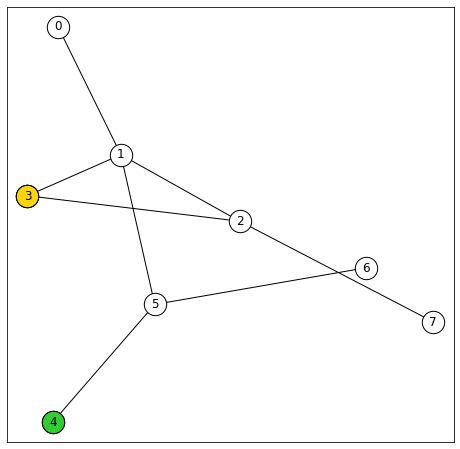

In [20]:
# Animation and simultaneous visualization of state, episode, step and reward

print_frames(frames)
fig, ax = plt.subplots(figsize = (8, 8))
ani = matplotlib.animation.FuncAnimation(fig, update, frames = len(frames), interval = 1000, repeat = True)
ani

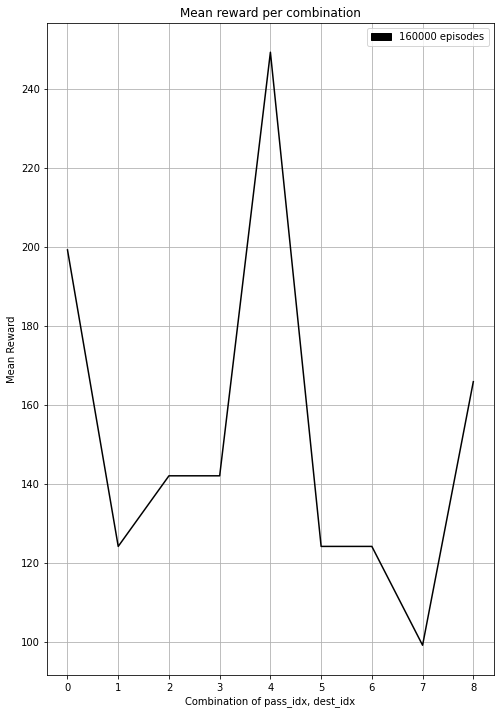

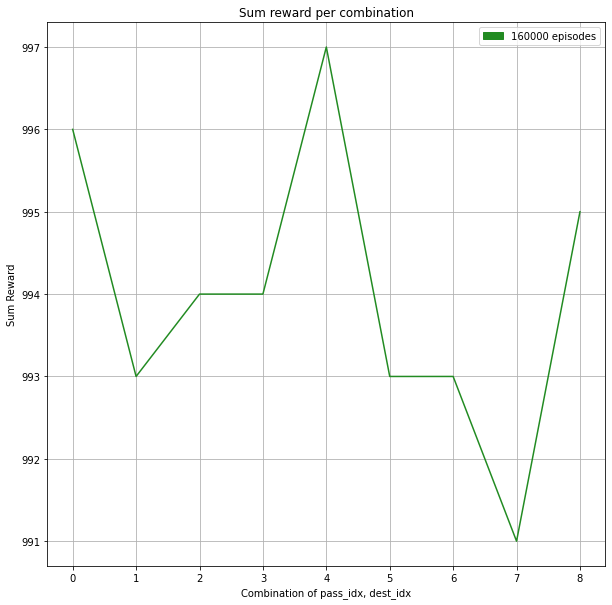

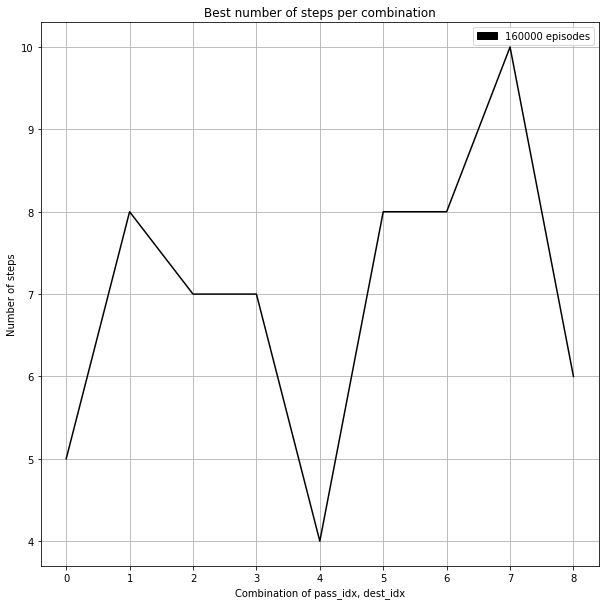

In [21]:
# Plot the mean reward for each combination

fig, ax = plt.subplots(figsize = (8, 12))
comb = [range(0, 9)]
black_patch = mpatches.Patch(color = "black", label = '160000 episodes')
plt.legend(handles = [black_patch])
plt.plot(Rewards_e, color = "black") 
plt.title("Mean reward per combination")
plt.xlabel('Combination of pass_idx, dest_idx')
plt.ylabel('Mean Reward')
plt.grid()


# Plot the sum reward for each combination

fig, ax = plt.subplots(figsize = (10, 10))
comb = [range(0, 9)]
green_patch = mpatches.Patch(color = "forestgreen", label = '160000 episodes')
plt.legend(handles = [green_patch])
plt.plot(Rewards_sum_e, color = "forestgreen")
plt.title("Sum reward per combination")
plt.xlabel('Combination of pass_idx, dest_idx')
plt.ylabel('Sum Reward')
plt.grid()


# Plot the number of steps for each combination

fig, ax = plt.subplots(figsize = (10, 10))
plt.legend(handles = [black_patch])
plt.plot(act_e, color = "black") 
plt.title("Best number of steps per combination")
plt.xlabel('Combination of pass_idx, dest_idx');
plt.ylabel('Number of steps')
plt.grid()